Install Required Libraries

In [1]:
# Prophet installation for Colab
!pip install prophet --quiet

Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

Simulate Virtual Sensor Data with Blackouts

In [3]:
def generate_virtual_sensor_data(hours=240):
    timestamps = pd.date_range(start="2025-01-01", periods=hours, freq="H")
    base_load = np.random.normal(loc=0.5, scale=0.1, size=hours)

    # Inject blackouts (set energy to 0)
    blackout_indices = np.random.choice(hours, size=int(hours * 0.1), replace=False)
    base_load[blackout_indices] = 0

    df = pd.DataFrame({'ds': timestamps, 'power_load': base_load})
    return df

Simulate Network Transmission

In [4]:
def simulate_network_disruption(df, loss_rate=0.05, jitter=0.02):
    noisy_df = df.copy()
    loss_indices = np.random.choice(len(df), size=int(len(df)*loss_rate), replace=False)
    noisy_df.loc[loss_indices, 'power_load'] = np.nan

    # Add jitter
    jitter_vals = np.random.normal(0, jitter, size=len(df))
    noisy_df['power_load'] += jitter_vals

    # Fix negatives and interpolate
    noisy_df['power_load'] = noisy_df['power_load'].clip(lower=0)
    noisy_df['power_load'] = noisy_df['power_load'].interpolate()
    return noisy_df

Fog Preprocessing (Rolling Filter)

In [5]:
def fog_level_filter(df, window=3):
    df_filtered = df.copy()
    df_filtered['power_load'] = df_filtered['power_load'].rolling(window=window, min_periods=1).mean()
    return df_filtered


Load Nigerian Public Holidays (Prophet Format)

In [6]:
nigeria_holidays = pd.DataFrame({
    'holiday': [
        'New Year’s Day', 'Eid al-Fitr', 'Eid al-Fitr',
        'Good Friday', 'Easter Monday', 'Labour Day',
        'Eid al-Adha', 'Eid al-Adha', 'Democracy Day',
        'Milad un-Nabi', 'Independence Day', 'Christmas Day', 'Boxing Day'
    ],
    'ds': pd.to_datetime([
        '2025-01-01', '2025-03-30', '2025-03-31', '2025-04-18',
        '2025-04-21', '2025-05-01', '2025-06-06', '2025-06-09',
        '2025-06-12', '2025-09-04', '2025-10-01', '2025-12-25', '2025-12-26'
    ])
})

Prophet Forecasting with Full Simulation Pipeline

/tmp/ipython-input-3-905710914.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(start="2025-01-01", periods=hours, freq="H")
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzqjz70y6/y8poy3oa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzqjz70y6/9ckef6en.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60387', 'data', 'file=/tmp/tmpzqjz70y6/y8poy3oa.json', 'init=/tmp/tmpzqjz70y6/9ckef6en.json', 'output', 'file=/tmp/tmpzqjz70y6/prophet_modelwewy69gk/prophet_model-20250701200857.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:08:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:08:57 - cmdstanpy - INFO 

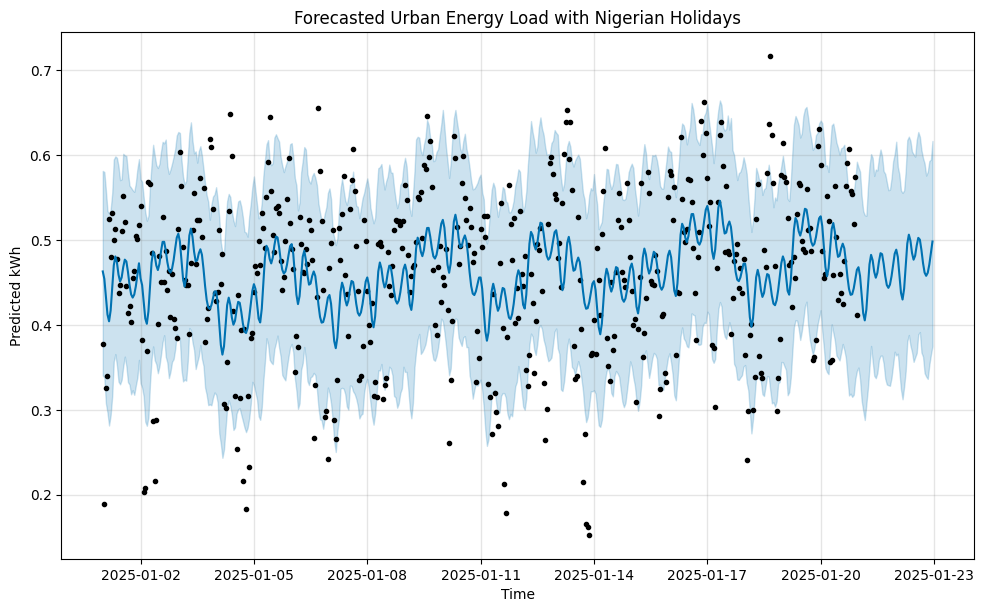

In [7]:
# Generate and simulate
sensor_data = generate_virtual_sensor_data(480)
network_data = simulate_network_disruption(sensor_data)
fog_data = fog_level_filter(network_data)

# Prophet expects column 'y' for values
forecast_df = fog_data.rename(columns={'power_load': 'y'})

# Initialize Prophet with holidays
model = Prophet(holidays=nigeria_holidays, daily_seasonality=True)
model.fit(forecast_df)

# Forecast next 48 hours
future = model.make_future_dataframe(periods=48, freq='H')
forecast = model.predict(future)

# Plot
model.plot(forecast)
plt.title("Forecasted Urban Energy Load with Nigerian Holidays")
plt.xlabel("Time")
plt.ylabel("Predicted kWh")
plt.grid(True)
plt.show()